In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
def random_percentage():
    return random.randint(0, 100) / 100

def random_bin():
    return random.randint(0, 1)

In [3]:
class Item (object):
    def __init__(self, weight, value):
        self.weight = weight
        self.value = value
        self.relevance = value / weight # used for reparation 

In [4]:
class Knapsack(object):

    # Max knapsack weight capacity
    CAPACITY = 120  

    # knapsack binary representation
    chromosome = []  
    
    # the fitness multiplier - used to penalize when multiplier < 1
    multiplier = 1  
    
    # name of the method used for infactible knapsack. Could be 'repare' or 'penalize'.
    infactible_fn = 'repare' 

    def __init__(self, chromosome, infactible_fn='repare'):
        self.infactible_fn = infactible_fn
        self.fill(chromosome)

    def fill(self, chromosome):
        self.chromosome = chromosome

    def size(self):
        return sum(self.chromosome)

    def weight(self, items):
        return sum([items[i].weight for i, allele in enumerate(self.chromosome) if allele is 1])

    def value(self, items):
        return sum([items[i].value for i, allele in enumerate(self.chromosome) if allele is 1])

    def is_feasible(self, items):
        return self.weight(items) <= self.CAPACITY

    def fitness(self, items):
        
        # repare or penalize the knapsack before calculate the fitness
        if self.infactible_fn == 'penalize':
            self.penalize(ITEMS)
        elif self.infactible_fn == 'repare':
            self.repare(ITEMS)
        
        return self.value(items) * self.multiplier

    def dump(self, items):
        return [self.size(), self.weight(items), self.value(items)] + self.chromosome

    def remove_item(self, i):
        self.chromosome[i] = 0

    def repare(self, items):
        while not self.is_feasible(items):
            less_relevant_item = None
            less_relevant_item_relevance = 0
            
            # find the less relevant item (relevance = value/weight)
            for i in range(len(self.chromosome)):
                if self.chromosome[i] is 0:
                    continue                    
                    
                if less_relevant_item is None or items[i].relevance < less_relevant_item_relevance:
                    less_relevant_item = i
                    less_relevant_item_relevance = items[i].relevance
                    
            self.remove_item(less_relevant_item)

    def penalize(self, items):
        if not self.is_feasible(items):
            self.multiplier = self.CAPACITY / (self.weight(items) * 2)

    def mutate(self, probability=0.05):
        for i in range(0, len(self.chromosome)):
            if random.uniform(0, 1) < probability:
                self.chromosome[i] = 1 if self.chromosome[i] is 0 else 0

    def crossover(self, other, probability=0.8):
        if random.uniform(0, 1) < probability:
            pos = random.randint(0, len(self.chromosome))
            child_1 = Knapsack(self.chromosome[pos:] + other.chromosome[:pos], self.infactible_fn)
            child_2 = Knapsack(other.chromosome[pos:] + self.chromosome[:pos], self.infactible_fn)
            return [child_1, child_2]
        return []

In [5]:
class CanonicalAG(object):
    
    # Maximum number of generations
    MAX_GEN=500
    
    # Maximum fitness
    MAX_FIT = 220
    
    # Available items to put on knapsack
    ITEMS = []
    
    # Default function to repare or penalize infactible knapsacks
    infactible_fn = 'repare'
    
    def __init__(self, items):
        self.ITEMS = items
        
    def generate_individual(self):
        chromosome = [random_bin() for i in range(0, len(self.ITEMS))]
        return Knapsack(chromosome, self.infactible_fn)
    
    def generate_population(self, size):
        return [self.generate_individual() for i in range(0, size)]

    def select_individual(self, population):
        # select an individual from population using the roulette method
        max = sum([individual.fitness(self.ITEMS) for individual in population])
        pick = random.uniform(0, max)
        current = 0
        for i, individual in enumerate(population):
            current += individual.fitness(ITEMS)
            if current > pick:
                return individual

    def select_roulette(self, population, n):
        # select n individuals from population
        population_selected = []
        population_copy = population.copy()
        for i in range(n):
            individual = self.select_individual(population_copy)
            population_selected.append(individual)
            population_copy.remove(individual)
        return population_selected
    
    def select_fittest(self, population, n):
        # select n fittest individuals from population
        population = sorted(population, key=lambda x: x.fitness(self.ITEMS), reverse=True)[:n]
        return population, population[0], population[0].fitness(self.ITEMS)
    
    def stagnated(self, fitnesses):
        if len(fitnesses) > 200:
            first = fitnesses[-1]
            for i in range(2, 200):
                if first is not fitnesses[-i]:
                    return False
            return True
        return False
   

    def run(self, N, R, Pc, Pm, infactible_fn):
        """
        :param N: population size
        :param R: number of individuals selected for reproduction
        :param Pc: crossover probability
        :param Pm: mutation probability
        :param infactible_fn: name of the function to use for infactible knapsacks, could be 'repare', 'penalize' or None
        """
        
        self.infactible_fn = infactible_fn
        
        results = []
        generation = 0 
        
        # generate the first population
        population = self.generate_population(N)
        
        # get fittest individual
        population, fittest, fitness = self.select_fittest(population, N)
        results.append([generation, fittest.weight(self.ITEMS), fittest.value(self.ITEMS), fittest.fitness(self.ITEMS)])
        
        while generation < self.MAX_GEN and fitness < self.MAX_FIT:  # and not self.stagnated(fitnesses):
            
            if len(results) is 1 or fitness > results[-2][3]:
                print("Generation", generation, " w =", fittest.weight(self.ITEMS), " v =", fittest.value(self.ITEMS), " fitness =", fitness)
            
            # select individuals for reproduction (roulette method)
            parents = self.select_roulette(population, R)

            # reproduce the selected individuals (by crossover probability Pc) 
            # and mutate children (by mutation probability Pm)
            children = []
            for i in range(0, len(parents) - 1, 2):
                siblings = parents[i].crossover(parents[i + 1], Pc)
                for sibling in siblings:
                    sibling.mutate(Pm)
                children.extend(siblings)
                
            # select the best individuals of this generation
            population, fittest, fitness = self.select_fittest(population + children, N)
            results.append([generation, fittest.weight(self.ITEMS), fittest.value(self.ITEMS), fittest.fitness(self.ITEMS)])
            
            # increment the generation
            generation += 1
            
        # plot the results
        df = pd.DataFrame(data=results, columns=['GENERATION', 'WEIGHT', 'VALUE', 'FITNESS'])
        df.plot(x='GENERATION', y='FITNESS')
        plt.show()
        print('====================================================', '\n')
            
        return fittest

In [6]:
# List of items available to put on the knapsack
ITEMS = [Item(item[0], item[1]) for item in [
    [3, 1], [8, 3], [12, 1], [2, 8], [8, 9], [4, 3], [4, 2], [5, 8], [1, 5], [1, 1], [8, 1], [6, 6], [4, 3], [3, 2],
    [3, 5], [5, 2], [7, 3], [3, 8], [5, 9], [7, 3], [4, 2], [3, 4], [7, 5], [2, 4], [3, 3], [5, 1], [4, 3], [3, 2],
    [7, 14], [19, 32], [20, 20], [21, 19], [11, 15], [24, 37], [13, 18], [17, 13], [18, 19], [6, 10], [15, 15], [25, 40], [12, 17], [19, 39]
]]

In [7]:
# create an AG instance
ag = CanonicalAG(ITEMS)

## Canonical AG with reparation

Generation 0  w = 119  v = 209  fitness = 209
Generation 345  w = 119  v = 210  fitness = 210
Generation 432  w = 120  v = 211  fitness = 211


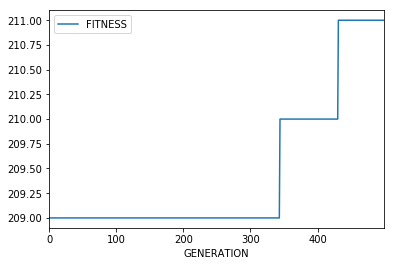


Generation 0  w = 120  v = 209  fitness = 209
Generation 186  w = 119  v = 212  fitness = 212
Generation 291  w = 120  v = 213  fitness = 213
Generation 335  w = 119  v = 215  fitness = 215


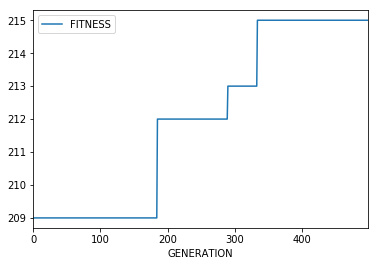


Generation 0  w = 119  v = 215  fitness = 215


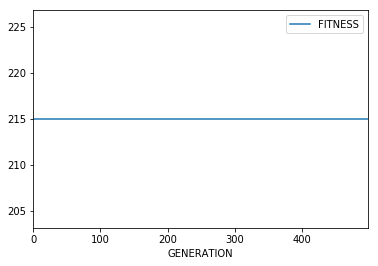


Generation 0  w = 120  v = 211  fitness = 211


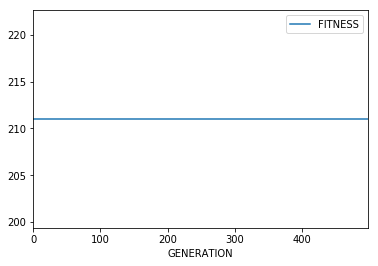


Generation 0  w = 118  v = 209  fitness = 209
Generation 305  w = 116  v = 211  fitness = 211
Generation 317  w = 118  v = 214  fitness = 214


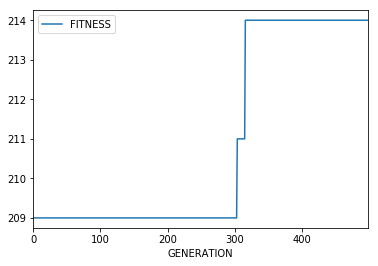


Generation 0  w = 120  v = 206  fitness = 206
Generation 68  w = 119  v = 210  fitness = 210
Generation 478  w = 120  v = 214  fitness = 214


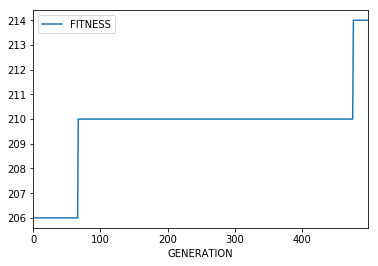


Generation 0  w = 118  v = 208  fitness = 208
Generation 113  w = 119  v = 209  fitness = 209
Generation 465  w = 118  v = 214  fitness = 214
Generation 483  w = 119  v = 215  fitness = 215


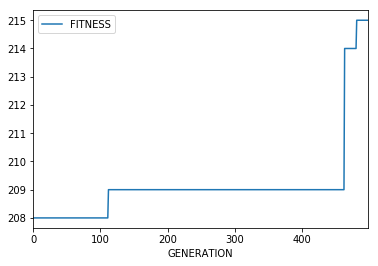


Generation 0  w = 119  v = 208  fitness = 208
Generation 51  w = 117  v = 209  fitness = 209
Generation 339  w = 120  v = 210  fitness = 210


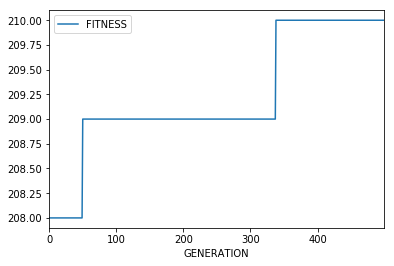


Generation 0  w = 120  v = 206  fitness = 206
Generation 55  w = 119  v = 212  fitness = 212


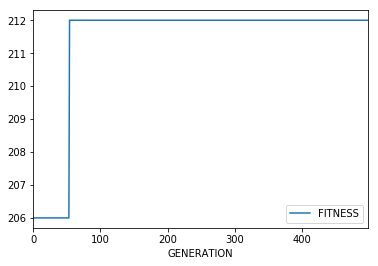


Generation 0  w = 118  v = 210  fitness = 210
Generation 482  w = 120  v = 211  fitness = 211


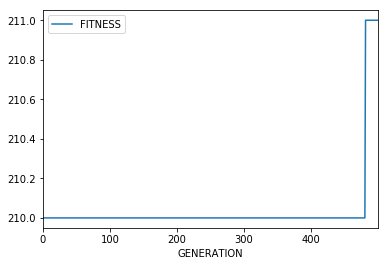


Average fitness for all executions = 212.8


In [8]:
results = []
for i in range(10):
    fittest = ag.run(N=100, R=10, Pc=0.8, Pm=0.3, infactible_fn='repare')
    results.append([i, fittest.chromosome, fittest.fitness(ITEMS)])

print("Average fitness for all executions =", sum(result[2] for result in results)/10)
pd.DataFrame(data=results).to_csv('repare.csv')

## Canonical AG with penalization

Generation 0  w = 110  v = 141  fitness = 141
Generation 4  w = 115  v = 144  fitness = 144
Generation 22  w = 107  v = 152  fitness = 152
Generation 26  w = 117  v = 153  fitness = 153
Generation 31  w = 111  v = 154  fitness = 154
Generation 57  w = 118  v = 157  fitness = 157
Generation 82  w = 114  v = 160  fitness = 160
Generation 89  w = 117  v = 162  fitness = 162
Generation 102  w = 116  v = 167  fitness = 167
Generation 104  w = 112  v = 178  fitness = 178


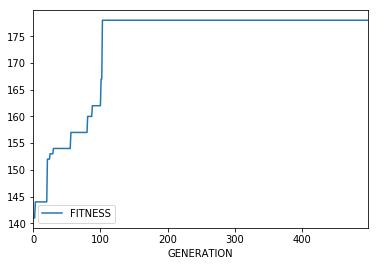


Generation 0  w = 101  v = 135  fitness = 135
Generation 4  w = 120  v = 159  fitness = 159
Generation 53  w = 120  v = 175  fitness = 175
Generation 62  w = 117  v = 176  fitness = 176
Generation 243  w = 118  v = 186  fitness = 186
Generation 357  w = 118  v = 191  fitness = 191


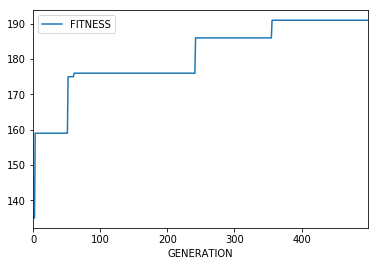


Generation 0  w = 118  v = 183  fitness = 183


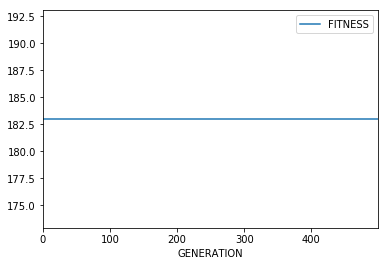


Generation 0  w = 100  v = 155  fitness = 155
Generation 42  w = 120  v = 162  fitness = 162
Generation 52  w = 118  v = 165  fitness = 165
Generation 69  w = 115  v = 166  fitness = 166
Generation 78  w = 120  v = 175  fitness = 175
Generation 194  w = 117  v = 186  fitness = 186


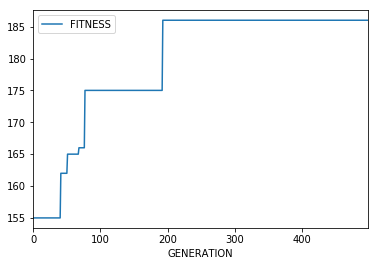


Generation 0  w = 106  v = 156  fitness = 156
Generation 9  w = 120  v = 162  fitness = 162
Generation 42  w = 103  v = 170  fitness = 170
Generation 80  w = 118  v = 172  fitness = 172
Generation 110  w = 120  v = 177  fitness = 177
Generation 171  w = 115  v = 188  fitness = 188


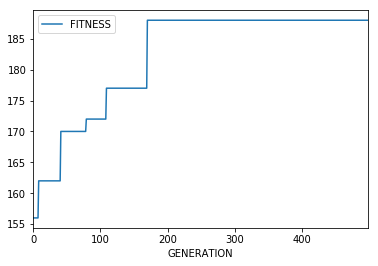


Generation 0  w = 110  v = 129  fitness = 129
Generation 5  w = 117  v = 141  fitness = 141
Generation 33  w = 113  v = 150  fitness = 150
Generation 36  w = 113  v = 156  fitness = 156
Generation 83  w = 111  v = 160  fitness = 160
Generation 95  w = 109  v = 164  fitness = 164
Generation 113  w = 110  v = 165  fitness = 165
Generation 148  w = 118  v = 167  fitness = 167
Generation 234  w = 119  v = 183  fitness = 183


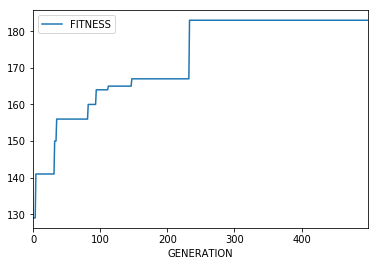


Generation 0  w = 118  v = 145  fitness = 145
Generation 45  w = 114  v = 150  fitness = 150
Generation 48  w = 114  v = 154  fitness = 154
Generation 69  w = 115  v = 158  fitness = 158
Generation 73  w = 120  v = 169  fitness = 169
Generation 234  w = 119  v = 171  fitness = 171
Generation 248  w = 118  v = 172  fitness = 172
Generation 277  w = 115  v = 174  fitness = 174


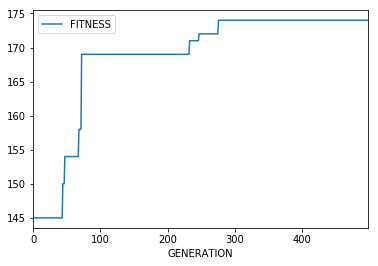


Generation 0  w = 108  v = 139  fitness = 139
Generation 9  w = 120  v = 141  fitness = 141
Generation 13  w = 110  v = 152  fitness = 152
Generation 33  w = 118  v = 157  fitness = 157
Generation 49  w = 119  v = 169  fitness = 169
Generation 316  w = 119  v = 172  fitness = 172
Generation 350  w = 119  v = 179  fitness = 179
Generation 461  w = 117  v = 181  fitness = 181


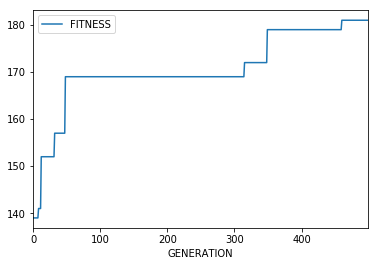


Generation 0  w = 120  v = 151  fitness = 151
Generation 22  w = 113  v = 161  fitness = 161
Generation 48  w = 113  v = 184  fitness = 184
Generation 254  w = 115  v = 185  fitness = 185


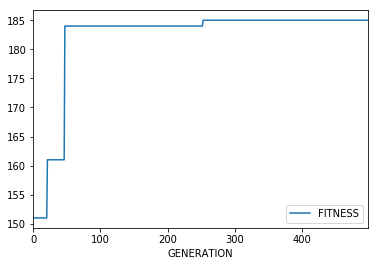


Generation 0  w = 113  v = 135  fitness = 135
Generation 4  w = 116  v = 159  fitness = 159
Generation 17  w = 119  v = 161  fitness = 161
Generation 106  w = 116  v = 178  fitness = 178


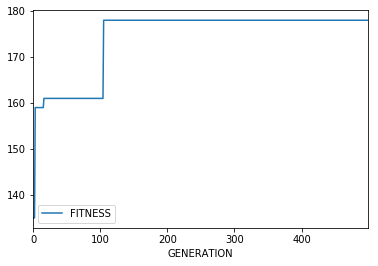


Average fitness for all executions = 182.7


In [11]:
results = []
for i in range(10):
    fittest = ag.run(N=100, R=10, Pc=0.8, Pm=0.05, infactible_fn='penalize')
    results.append([i, fittest.chromosome, fittest.fitness(ITEMS)])

print("Average fitness for all executions =", sum(result[2] for result in results)/10)
pd.DataFrame(data=results).to_csv('penalization.csv')